# Agent

In [ ]:
%pip install -U langchain_anthropic
%pip install langgraph
%pip install langchain_community

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\thswj\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\thswj\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/60.9 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.9 kB ? eta -:--:--
     ---------------------------------------- 60.9/60.9 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/76.3 kB ? eta -:--:--
     ---------------------------------------- 76.3/76.3 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.5 MB 10.0 MB/s eta 0:00:01
   ---------------- ----------------------- 1.1/2.5 MB 11.2 MB/s eta 0:00:01
   ------------------------- -------------- 1.6/2.5 MB 11.5 MB/s eta 0:00:01
   ----------------------------------- ---- 2.2/2.5 MB 11.9 MB/s eta 0:00:01
   ---------------------------------------  2.5/2.5 MB 12.4 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 10.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/451.4 kB ? eta -:--:--
   ------------------


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\thswj\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import getpass
import os
import json
from IPython.display import Image, display

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_anthropic import ChatAnthropic

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage



In [ ]:
def sent_env(var: str):
  if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"{var}: ")

claude_key = ''
sent_env('claude_api_key')

In [ ]:
def visualize_graph(graph):
  from IPython.display import Image, display
  try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
  except Exception:
    pass

## 기본 챗봇

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_bulider = StateGraph(State)

In [ ]:
llm = ChatAnthropic(model = "claude-3-haiku-20240307")

def chatbot(state: State):
    return {'messages': [llm.invoke(state['messages'])]}

graph_bulider.add_node('chatbot', chatbot)

In [ ]:
# graph_builder.add_edge(START, 'chatbot')
# graph_builder.add_edge('chatbot', END)

graph_bulider.set_entry_point("chatbot")
graph_bulider.set_finish_point("chatbot")

graph = graph_bulider.compile()

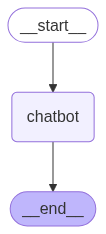

In [ ]:
visualize_graph(graph)

In [ ]:
# 대화 시작
while True:
    user_input = input('User: ')
    if user_input.lower() in ['quit', 'exit','q']:
        print('대화종료')
        break
    for event in graph.stream({'messages': ('user', user_input)}):
        for value in event.values():
            print('User:', user_input)
            print('Assistant:', value['messages'][-1].content)

대화종료


## chatbot > agent

In [ ]:
%pip install -U tavily-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\thswj\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
tavily_key = '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'
sent_env('tavily_api_key')

In [ ]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("LangGraph에서 '노드'란 무엇인가요?")

[{'title': '3장: LangGraph의 핵심 구성요소 – 노드, 엣지, 상태 관리 - 틸노트',
  'url': 'https://tilnote.io/pages/68156a79baa37b745385c298',
  'content': "노드는 LangGraph 워크플로우에서 하나하나의 작업 구간을 가리킨다. 말하자면 정보 추출, 외부 도구 호출, LLM 응답 생성 등 실제로 '일'이 이루어지는",
  'score': 0.9121316},
 {'title': '23화 22. LangGraph 기본과 응용',
  'url': 'https://brunch.co.kr/@@hqFh/132',
  'content': 'LangGraph(랭그래프)는 각 노드의 처리를 Python함수 또는 Runnable객체로 정의합니다. 이 함소 또는 Runnable객체의 인수는 상태정의에 지정된 유형과 일치해야 합니다.',
  'score': 0.78493005}]

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [ ]:
class BasicToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
            if messages := inputs.get('messages', []):
                message = messages[-1]

            else:
                raise ValueError('No message foun in inputs')
            outputs = []
            for tool_call in message.tool_calls:
                tool_result = self.tools_by_name[tool_call['name']].invoke(
                        tool_call['agrs']
                        )
                outputs.append(
                    ToolMessage(
                        content=json.dumps(tool_result),
                        name=tool_call['name'],
                        tool_call_id = tool_call['id'],
                    )
                )
            return {'messages': outputs}

tool_node = BasicToolNode(tools)
graph_builder.add_node('tools', tool_node)
